In [1]:
from google.colab import files

uploaded = files.upload()  # otvorí okno, kde nahrám súbor final_data.csv


Saving final_data.csv to final_data.csv


# Poissonov model

In [2]:
#poissonov model
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv(list(uploaded.keys())[0], parse_dates=['datetime'])

# spočítam všetky hodiny pre každý deň a trasu
daily_df = df.groupby(['date', 'nazov'], as_index=False)['pocet_total'].sum()
daily_df.rename(columns={'pocet_total': 'daily_total'}, inplace=True)

# vyberiem priemernú teplotu daného dňa
# v prípade, že by sa náhodou niekde objavila iná teplota počas rovnakého dňa, použijem
daily_temp = df[['date', 'nazov', 'tavg']].drop_duplicates()
daily_df = daily_df.merge(daily_temp, on=['date','nazov'])

poisson_model = smf.glm(formula='daily_total ~ tavg', data=daily_df,
                        family=sm.families.Poisson()).fit()
print("POISSONOV MODEL")
print(poisson_model.summary())

# interpretácia
coef = poisson_model.params['tavg']
exp_coef = np.exp(coef)
print(f"\nInterpretácia: Koeficient pre tavg = {coef:.3f}")
print(f"Multiplikatívny efekt = exp(coef) = {exp_coef:.3f}")
print(f"Vyplýva že zvýšenie teploty o 1°C zvyšuje očakávaný denný počet cyklistov {exp_coef:.3f}-násobne.")

# diagnostika overdisperzie
pearson_chi2 = sum(poisson_model.resid_pearson**2)
df_resid = poisson_model.df_resid
dispersion_ratio = pearson_chi2 / df_resid
print(f"\nOverdispersion ratio (Pearson Chi2 / df) = {dispersion_ratio:.3f}")

if dispersion_ratio > 1.5:
    print("!!NADPRIEMERNA DISPERZIA")
else:
    print("!!PRIJATELNA DISPERZIA.")


POISSONOV MODEL
                 Generalized Linear Model Regression Results                  
Dep. Variable:            daily_total   No. Observations:                19129
Model:                            GLM   Df Residuals:                    19127
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4443e+06
Date:                Fri, 09 Jan 2026   Deviance:                   6.7550e+06
Time:                        17:28:06   Pearson chi2:                 8.17e+06
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0391      0.001   5

Poissonov model naznačil, že teplota má významný vplyv na denný počet cyklistov (exp(coef) = 1.075, p < 0.001), ale dáta vykazovali extrémnu nadmernú disperziu (Pearson Chi² / df = 427), preto sme použili negatívnu binomickú regresiu, ktorá poskytuje spoľahlivejšie odhady a potvrzuje významný pozitívny efekt teploty.

# Negatívna binomická regresia

In [3]:
#negatívna binomická regresia
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv("final_data.csv", parse_dates=['datetime'])
daily_df = df.groupby('date').agg({'pocet_total': 'sum', 'tavg': 'mean'}).reset_index()

# vytvorenie modelu
nb_model = smf.glm('pocet_total ~ tavg', data=daily_df,
                    family=sm.families.NegativeBinomial()).fit()

print("NEGATÍVNA BINOMICKÁ REGRESIA")
print(nb_model.summary())

# interpretácia
coef = nb_model.params['tavg']
multiplicative_effect = np.exp(coef)
print(f"\nInterpretácia:")
print(f"Koeficient pre tavg = {coef:.3f}")
print(f"Multiplikatívny efekt = {multiplicative_effect:.3f}")
print(f"Každé +1°C zvyšuje očakávaný denný počet cyklistov o { (multiplicative_effect-1)*100:.1f}%")

# len pre info, overdisperzia?
pearson_chi2 = sum(nb_model.resid_pearson**2)
dispersion_ratio = pearson_chi2 / nb_model.df_resid
print(f"Pearson chi2 / df = {dispersion_ratio:.2f}")



NEGATÍVNA BINOMICKÁ REGRESIA
                 Generalized Linear Model Regression Results                  
Dep. Variable:            pocet_total   No. Observations:                 1085
Model:                            GLM   Df Residuals:                     1083
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10608.
Date:                Fri, 09 Jan 2026   Deviance:                       293.61
Time:                        17:28:08   Pearson chi2:                     267.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3560
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6431  

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


# Kód vizualizácie

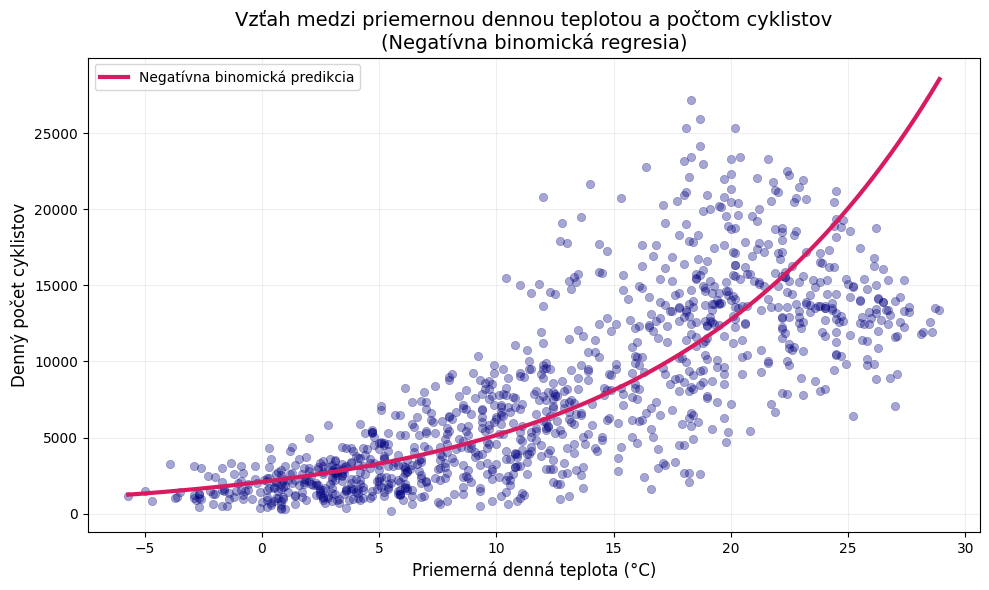

In [4]:
# vizualizácia
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=daily_df,
    x='tavg',
    y='pocet_total',
    alpha=0.35,
    color='navy',
    edgecolor=None
)

tavg_vals = np.linspace(daily_df['tavg'].min(), daily_df['tavg'].max(), 100)
pred_vals = nb_model.predict(pd.DataFrame({'tavg': tavg_vals}))

plt.plot(
    tavg_vals,
    pred_vals,
    color='#D81B60',  # cyklamenová
    linewidth=3,
    label='Negatívna binomická predikcia'
)

plt.xlabel("Priemerná denná teplota (°C)", fontsize=12)
plt.ylabel("Denný počet cyklistov", fontsize=12)
plt.title(
    "Vzťah medzi priemernou dennou teplotou a počtom cyklistov\n(Negatívna binomická regresia)",
    fontsize=14
)

plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
